In [441]:
import yaml
import json
import sys
import os
import itertools
import numpy as np
import scipy as sp
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import cmocean

from matplotlib.backends.backend_pdf import PdfPages

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

%matplotlib inline

In [462]:
HFB_OBJECTS = ['FractCoord', 'UnitCell',
               'HoppingDiagonal', 'HoppingOffdiagonal',
               'InteractionDiagonal', 'InteractionOffdiagonal',
               'FullHamiltonian', 'HFBSolver', 'HFBComputer']

def jsonconv(obj):
    if isinstance(obj, int):
        return obj
    elif isinstance(obj, float):
        return obj
    elif isinstance(obj, str):
        return obj
    elif isinstance(obj, list):
        return [jsonconv(o) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(jsonconv(o) for o in obj)
    elif isinstance(obj, dict):
        if 'type' in obj:
            if obj['type'] == 'Symbol':
                return obj['value']
            elif obj['type'] == 'Tuple':
                return tuple(jsonconv(obj['value']))
            elif obj['type'] in HFB_OBJECTS:
                return {k: jsonconv(v) for k,v in obj.items()}
            else:
                print(obj['type'])
                print(obj.keys())
                raise TypeError("HA")
        elif 'real' in obj and 'imag' in obj:
            return complex(obj['real'], obj['imag'])
        elif 're' in obj and 'im' in obj:
            return complex(obj['re'], obj['im'])
        else:
            return {k: jsonconv(v) for k,v in obj.items()}
    else:
        return obj

In [515]:
#dirname='Results/nn_zigzag/out_w=24_n1=24_mAB=0.050_U=0.000_V=-2.900'
dirname='Results/nn_zigzag_largegap/out_w=24_n1=24_mAB=0.500_U=0.000_V=-3.200'
#dirname='Results/nn_zigzag_largegap/out_w=24_n1=24_mAB=0.500_U=0.000_V=0.000'
dirname='Results/nn_zigzag_lg_48/out_w=48_n1=24_mAB=0.500_U=0.000_V=-3.200'
#dirname='Results/nn_zigzag_lg_48/out_w=48_n1=24_mAB=0.500_U=0.000_V=0.000'


In [516]:
with open(os.path.join(dirname,'hamiltonian.json'), 'r') as f:
    hamiltonian = json.load(f)
    hamiltonian = jsonconv(hamiltonian)
with open(os.path.join(dirname,'hfbcomputer.json'), 'r') as f:
    hfbcomputer = json.load(f)
    hfbcomputer = jsonconv(hfbcomputer)

In [517]:
with open(os.path.join(dirname,'result_concise.yaml'), 'r') as f:
    for result in yaml.load_all(f):
        pass

In [518]:
with open(os.path.join(dirname,'eigenvalues.json'), 'r') as f:
    eigen = json.load(f)

In [519]:
Deltas = jsonconv(result['Delta'])

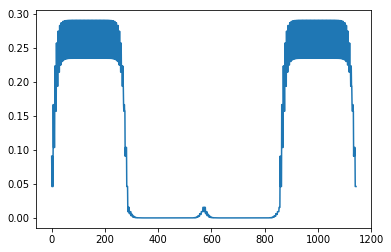

In [520]:
plt.plot( np.abs(Deltas) )

In [521]:
unitcell = hamiltonian['unitcell']
hoppings = hamiltonian['hoppings']

In [522]:
latticevectors = np.array(unitcell['latticevectors'])
orbitals = unitcell['orbitals']

In [523]:
print(latticevectors)
def oc(idx):
    fc = orbitals[idx-1][1]
    fc = np.array(fc['whole']) + np.array(fc['fraction'])
    return np.dot(fc, latticevectors)

[[  3.46410162   0.        ]
 [-41.56921938  72.        ]]


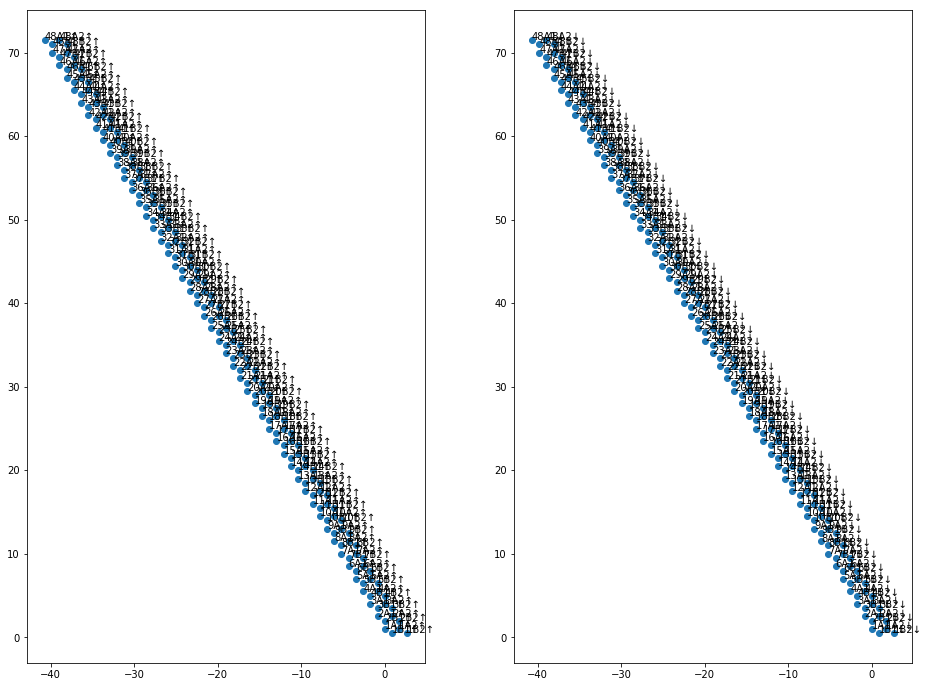

In [524]:

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

upcoords = []
dncoords = []

def signature(orbname):
    ret = []
    for o in orbname:
        if o == 'UP':
            ret.append(r'↑')
        elif o == 'DN':
            ret.append(r'↓')
        else:
            ret.append(str(o))
    return '{}'.format(''.join(ret))

for (orbname, fc) in orbitals:
    r = np.dot( np.array(fc['fraction']) + np.array(fc['whole']), latticevectors)
    if orbname[-1] == 'UP':
        upcoords.append(r)
        ax1.annotate(signature(orbname), xy=r, fontsize=10)
    else:
        dncoords.append(r)
        ax2.annotate(signature(orbname), xy=r, fontsize=10)
        
upcoords = np.array(upcoords)
dncoords = np.array(dncoords)

ax1.plot(upcoords[:,0], upcoords[:,1], 'o')
ax1.set_aspect(1.0)

ax2.plot(dncoords[:,0], dncoords[:,1], 'o')
ax2.set_aspect(1.0)


# Bond plots

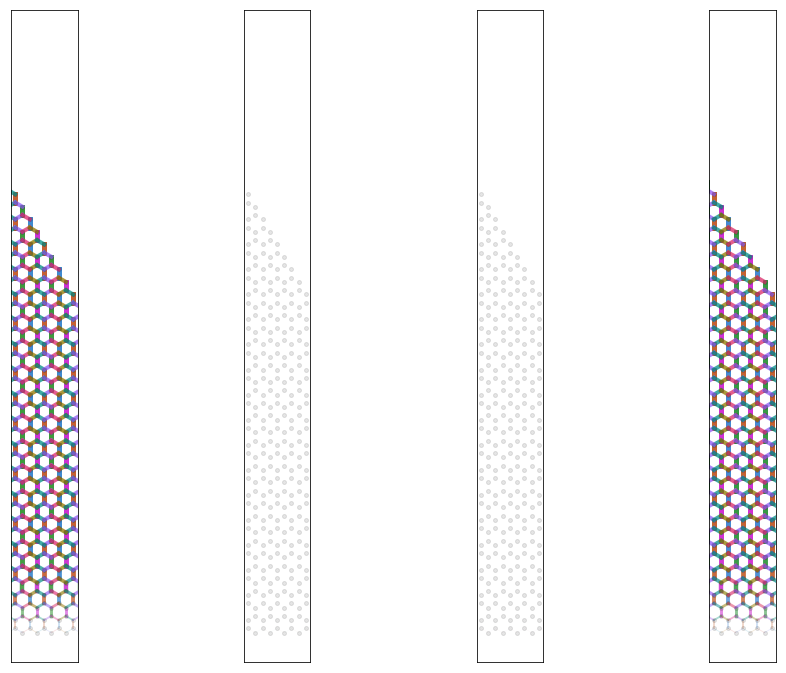

In [495]:
TOLERANCE = 1E-6

fig = plt.figure(figsize=(16,12))
axs = [fig.add_subplot(1,4,i) for i in [1,2,3,4]]

panelindices = {
    ('UP','UP'): 0,
    ('UP','DN'): 1,
    ('DN','UP'): 2,
    ('DN','DN'): 3
}
for ax in axs:
    ax.set_aspect(1.0)
    for i1, i2 in itertools.product(range(-9, 8), [0]):
        r0 = np.dot([i1,i2], latticevectors)
        ax.plot(r0[0] + upcoords[:,0],
                r0[1] + upcoords[:,1],
                'o',
                zorder=10,
                color='k',
                alpha=0.1,
               markersize=4)

maxDelta = np.max(np.abs(Deltas))
for ((isdiag, rowindex, colindex, vec, srcs), Delta) in zip(hfbcomputer['Delta_registry'], Deltas):
    row_orbname, row_fc = orbitals[rowindex-1]
    col_orbname, col_fc = orbitals[colindex-1]
    if row_orbname[1] == 'A':
        vec = np.array(vec)
    elif row_orbname[1] == 'B':
        (rowindex, colindex) = (colindex, rowindex)
        (row_orbname, col_orbname) = (col_orbname, row_orbname)
        vec = -np.array(vec)
        Delta = -Delta
        
    panelindex = panelindices[ row_orbname[-1], col_orbname[-1]]
    
    if np.abs(Delta) < TOLERANCE: continue
        
    c = cmocean.cm.phase((np.angle(Delta) / (2*np.pi)) % 1.0)
    alpha = np.abs(Delta) / maxDelta
    #for i1, i2 in itertools.product([0], [-2,-1,0,1]):
    for i1, i2 in itertools.product(range(-9, 8), [0]):
        r0 = np.dot([i1,i2], latticevectors)
        ri = oc(rowindex) + r0
        rj = ri + vec
        axs[panelindex].plot([ri[0], rj[0]], [ri[1], rj[1]],
                             '-',
                             linewidth=alpha*5,
                             color=c,
                             alpha=alpha)
        #axs[panelindex].plot([ri[0], rj[0]], [ri[1], rj[1]], '-', linewidth=np.abs(Delta)*4, color=c)

for ax in axs:
    ax.set_xlim(-4,4)
#    ax.set_ylim(-5,5)
    ax.set_xticks([])
    ax.set_yticks([])
#plt.savefig('edgemode.pdf', dpi=300, bbox_inches='tight')
#plt.savefig('edgemode.png', dpi=300, bbox_inches='tight')


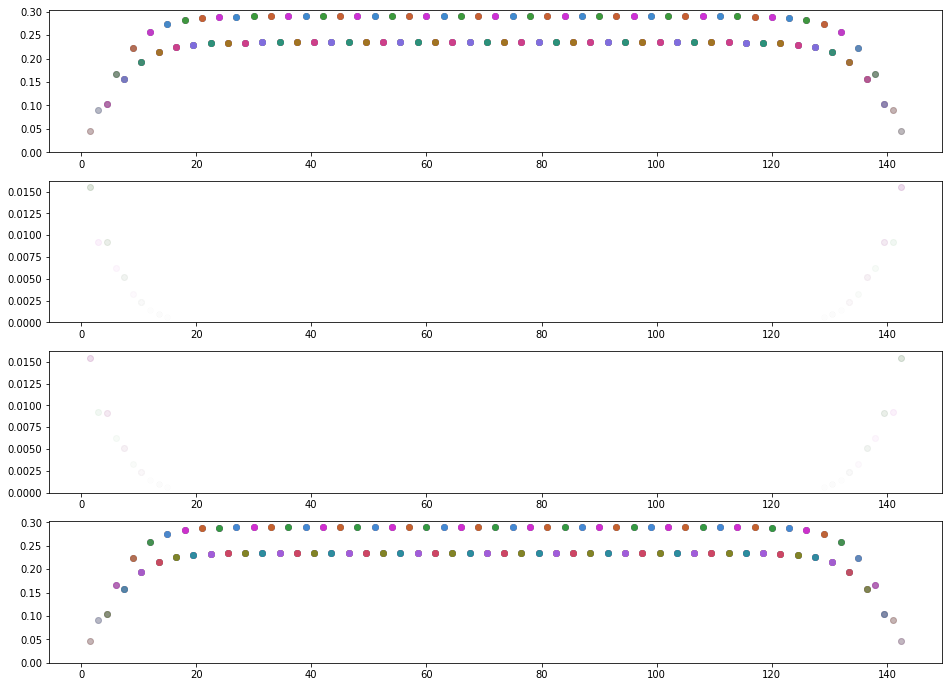

In [525]:
TOLERANCE = 1E-6

fig = plt.figure(figsize=(16,12))
axs = [fig.add_subplot(4,1,i) for i in [1,2,3,4]]

panelindices = {
    ('UP','UP'): 0,
    ('UP','DN'): 1,
    ('DN','UP'): 2,
    ('DN','DN'): 3
}

maxDelta = np.max(np.abs(Deltas))
for ((isdiag, rowindex, colindex, vec, srcs), Delta) in zip(hfbcomputer['Delta_registry'], Deltas):
    row_orbname, row_fc = orbitals[rowindex-1]
    col_orbname, col_fc = orbitals[colindex-1]
    if row_orbname[1] == 'A':
        vec = np.array(vec)
    elif row_orbname[1] == 'B':
        (rowindex, colindex) = (colindex, rowindex)
        (row_orbname, col_orbname) = (col_orbname, row_orbname)
        vec = -np.array(vec)
        Delta = -Delta
        
    panelindex = panelindices[ row_orbname[-1], col_orbname[-1]]
    
    if np.abs(Delta) < TOLERANCE:
        continue
        
    #c = mpl.cm.hsv((np.angle(Delta) / (2*np.pi)) % 1.0)
    c = cmocean.cm.phase((np.angle(Delta) / (2*np.pi)) % 1.0)
    #for i1, i2 in itertools.product([-2,-1,0,1,2], [-2,-1,0,1,2]):
    alpha = np.abs(Delta) / maxDelta
    ri = oc(rowindex)
    rj = ri + vec
    #axs[panelindex].plot([ri[0] + rj[0]], [ri[1] + rj[1]], 'o', color=c, alpha=alpha)
    #axs[panelindex].plot([ri[0] + rj[0]], [np.abs(Delta)], 'o', color=c)
    #axs[panelindex].plot([ri[0] + rj[0]], [np.abs(Delta)], 'o', color=c, alpha=alpha)
    axs[panelindex].plot([ri[1] + rj[1]], [np.abs(Delta)], 'o', color=c, alpha=alpha)
    #axs[panelindex].plot([ri[0], rj[0]], [ri[1], rj[1]], '-', linewidth=np.abs(Delta)*4, color=c)

for ax in axs:
    pass
#    ax.set_xlim(-4,4)
    ax.set_ylim(0,None)
    #ax.set_xticks([])
    #ax.set_yticks([])

## Solution

In [526]:
eigenvalues = np.array(eigen['eigenvalues'])
momentums =  np.array(eigen["momentums"])
#ks = np.sqrt( np.sum(np.abs(momentums)**2, axis=(1,2)) )
ks = momentums[0,:,0]

In [527]:
ks

array([ 0.        ,  0.01511499,  0.03022999,  0.04534498,  0.06045998,
        0.07557497,  0.09068997,  0.10580496,  0.12091996,  0.13603495,
        0.15114995,  0.16626494,  0.18137994,  0.19649493,  0.21160993,
        0.22672492,  0.24183992,  0.25695491,  0.2720699 ,  0.2871849 ,
        0.30229989,  0.31741489,  0.33252988,  0.34764488,  0.36275987,
        0.37787487,  0.39298986,  0.40810486,  0.42321985,  0.43833485,
        0.45344984,  0.46856484,  0.48367983,  0.49879483,  0.51390982,
        0.52902481,  0.54413981,  0.5592548 ,  0.5743698 ,  0.58948479,
        0.60459979,  0.61971478,  0.63482978,  0.64994477,  0.66505977,
        0.68017476,  0.69528976,  0.71040475,  0.72551975,  0.74063474,
        0.75574974,  0.77086473,  0.78597972,  0.80109472,  0.81620971,
        0.83132471,  0.8464397 ,  0.8615547 ,  0.87666969,  0.89178469,
        0.90689968,  0.92201468,  0.93712967,  0.95224467,  0.96735966,
        0.98247466,  0.99758965,  1.01270465,  1.02781964,  1.04

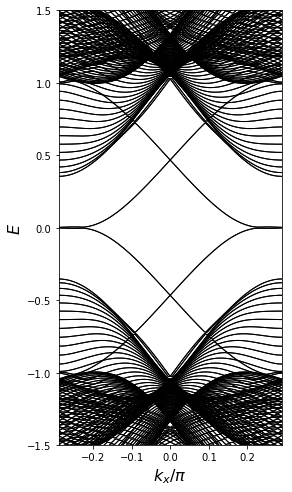

In [529]:
plt.figure(figsize=(4,8))
#xs = np.hstack([ks, ks + 2*np.pi / 6.0])
xs = np.hstack([ks/np.pi - 1/(np.sqrt(3)), ks/np.pi])
for i in range(eigenvalues.shape[1]):
    ys = np.hstack([eigenvalues[:,i],eigenvalues[:,i]])
    plt.plot(xs, ys, 'k-', linewidth=1)
#plt.ylim(-1.5, 1.5)
plt.xlabel('$k_x/\pi$', fontsize=16)
plt.ylabel('$E$', fontsize=16)
#plt.xlim(np.min(ks), np.max(ks) + 2*np.pi/6.0)
plt.ylim(-1.5, 1.5)
plt.xlim(np.min(xs), np.max(xs))
#plt.xlim(-0.5 / np.sqrt(3.0)- 0.1, 0.5 / np.sqrt(3.0) + 0.1)
plt.xlim(-0.5 / np.sqrt(3.0), 0.5 / np.sqrt(3.0))
plt.savefig('foo.png', dpi=300, bbox_inches='tight')


In [513]:
pwd

'/Users/lee.8024/Dropbox/code/TMDStrip'

In [ ]:
mv 

In [380]:
eigenvalues[60,:]

array([ -2.65368490e+00,  -2.65368490e+00,  -2.63282901e+00,
        -2.63282901e+00,  -2.60267765e+00,  -2.60267765e+00,
        -2.56507752e+00,  -2.56507752e+00,  -2.52082928e+00,
        -2.52082928e+00,  -2.48256139e+00,  -2.48256139e+00,
        -2.48255753e+00,  -2.48255753e+00,  -2.47008425e+00,
        -2.47008425e+00,  -2.46820928e+00,  -2.46820928e+00,
        -2.46818931e+00,  -2.46818931e+00,  -2.44683248e+00,
        -2.44683248e+00,  -2.44677338e+00,  -2.44677338e+00,
        -2.41944099e+00,  -2.41944099e+00,  -2.41930995e+00,
        -2.41930995e+00,  -2.41270800e+00,  -2.41270800e+00,
        -2.38647031e+00,  -2.38647031e+00,  -2.38623151e+00,
        -2.38623151e+00,  -2.34887390e+00,  -2.34887390e+00,
        -2.34836544e+00,  -2.34836544e+00,  -2.34797652e+00,
        -2.34797652e+00,  -2.31541855e+00,  -2.31541855e+00,
        -2.31304664e+00,  -2.31304664e+00,  -2.30605403e+00,
        -2.30605403e+00,  -2.30540969e+00,  -2.30540969e+00,
        -2.28505297e+00,

In [ ]:
coords = []
for orbital in data['UnitCell']['Orbitals']:
    fractcoord = orbital['Coord']
    coord = np.array(fractcoord['fraction']) + np.array(fractcoord['whole'])
    coord = a1 * coord[0] + a2 * coord[1]
    orbital['Index']
    orbital['Name']
    coords.append(coord)
coords = np.array(coords)

fig = plt.figure()
ax = fig.gca()
ax.plot(coords[:,0], coords[:,1], 'o')
ax.set_aspect(1.0)
ax.arrow(0,0, a1[0], a1[1], length_includes_head=True)
ax.arrow(0,0, a2[0], a2[1], length_includes_head=True)
ax.set_xlim(-0.5, a1[0] + a2[0] + 0.5)
ax.set_ylim(-0.5, a1[1] + a2[1] + 0.5)


In [ ]:
def foo():
    fig = plt.figure()
    ax0 = fig.gca()
    ax = fig.add_axes([0.7, 0.2, 0.20, 0.20], polar=True)
    
    angles = np.linspace(0, 2*np.pi, 181, endpoint=True)
    radii = np.linspace(0.5, 1.0, 16, endpoint=True)
    angleg, radiusg = np.meshgrid(angles, radii)
    
    ax.pcolor(angleg, radiusg, angleg, cmap=cmocean.cm.phase)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0,0, r'$\mathrm{arg}(\Delta_{ij})$',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=12)
foo()